####   CONSOLIDATED SCRIPT FOR RUNNING THE PROPOSED MEESHO RETURN RISK MODEL

#### MODEL TRAINING

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Load training data
train_df = pd.read_csv('data/buyer_features_train.csv')

exclude_cols = ['customer_id', 'risk_category', 'fraud_label']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X = train_df[feature_cols]
y = train_df['fraud_label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

print("Model trained on training data.")


#### MODEL EVALUATION ON TEST DATA

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

# Load training data and test data
train_df = pd.read_csv('data/buyer_features_train.csv')
test_df = pd.read_csv('data/test_return_requests_noisy.csv')

exclude_cols = ['customer_id', 'risk_category', 'fraud_label']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

# Prepare train data for scaler and model recreation
X_train = train_df[feature_cols]
y_train = train_df['fraud_label']

# Prepare test data
X_test = test_df[feature_cols]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model on full training data (again since no saved model)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict test probabilities
test_probs = rf_model.predict_proba(X_test_scaled)[:, 1]
test_preds = (test_probs > 0.5).astype(int)

test_df['predicted_risk'] = test_probs
test_df['flagged'] = test_preds

print("Test Classification Report:")
print(classification_report(test_df['true_label'], test_preds))
print("Test ROC-AUC Score:", roc_auc_score(test_df['true_label'], test_probs))

test_df[['test_order_id', 'customer_id', 'return_reason', 'predicted_risk', 'flagged', 'true_label']].to_csv('test_risk_predictions.csv', index=False)
print("Saved test risk predictions to 'test_risk_predictions.csv'")


Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        53
           1       0.98      0.87      0.92        47

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Test ROC-AUC Score: 0.9482135688478522
Saved test risk predictions to 'test_risk_predictions.csv'


#### GRAPHS  FOR VISUALIZATION - TRAIN & TEST

#### TRAIN

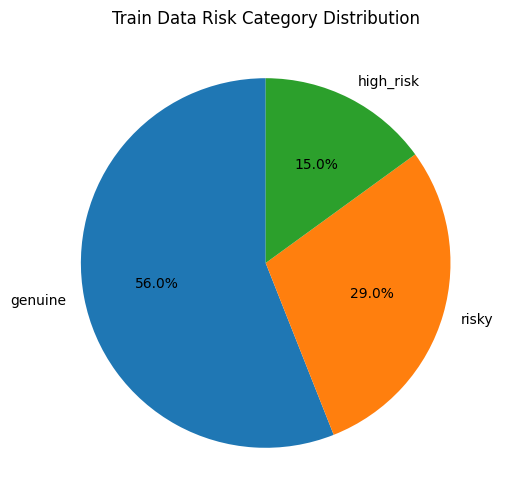

C:\Users\naray\AppData\Local\Temp\ipykernel_35956\1586708798.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_reasons.values, y=mean_reasons.index, palette='Blues_r')


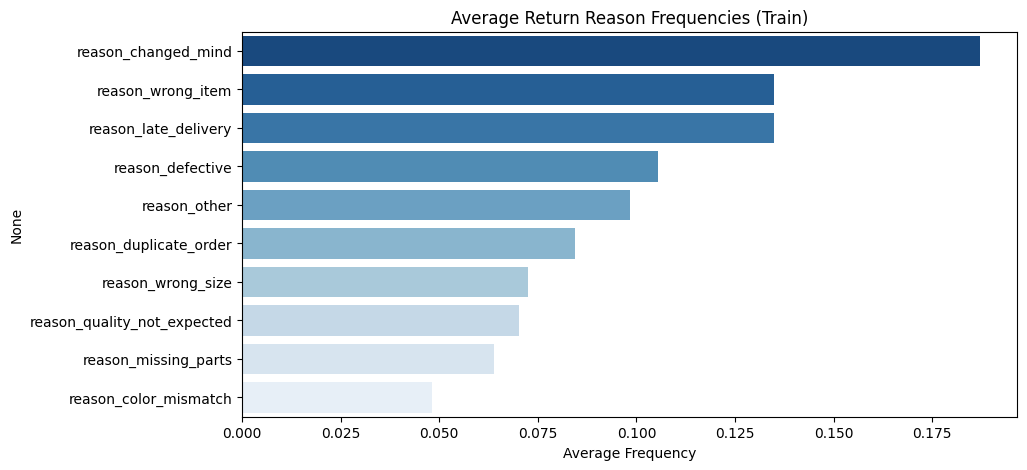

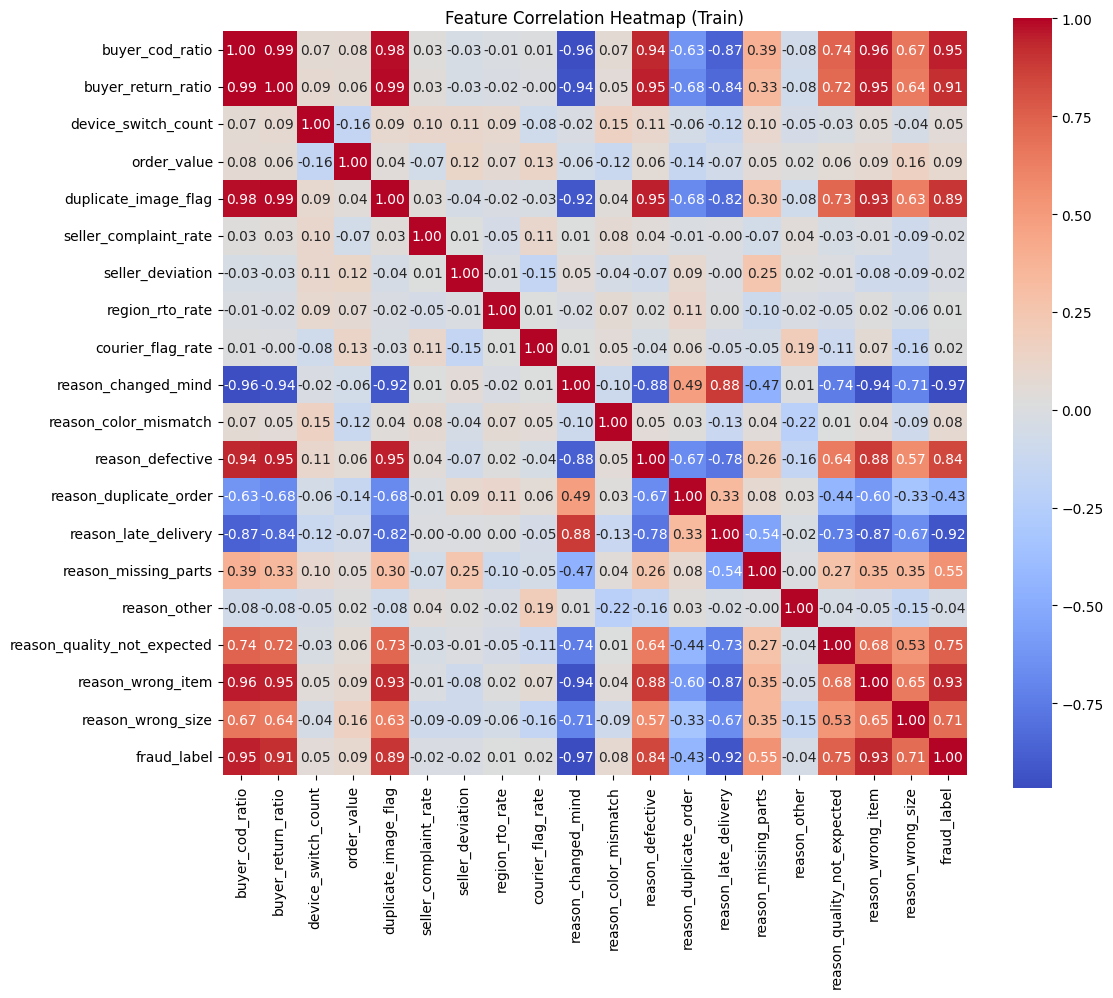

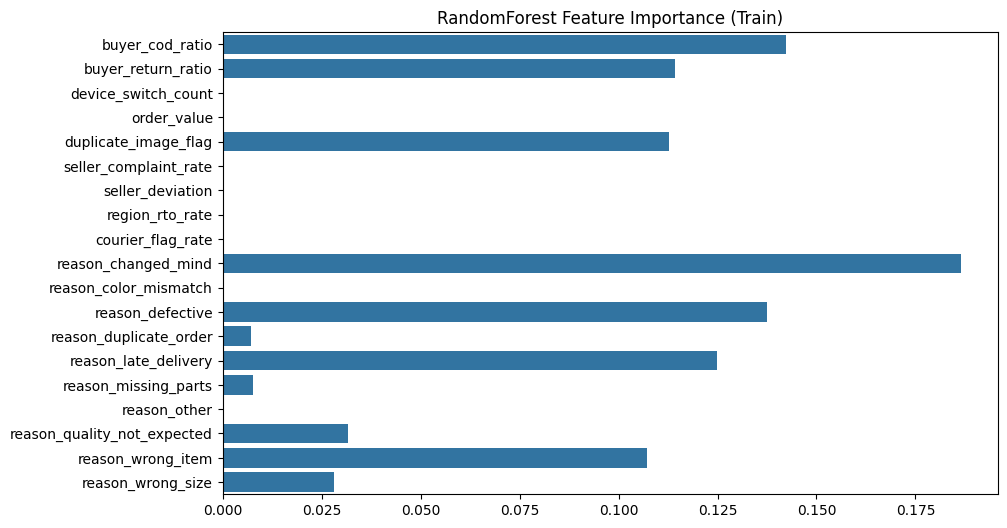

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.makedirs('results', exist_ok=True)


# Load train data
train_df = pd.read_csv('data/buyer_features_train.csv')

# 1. Class distribution pie chart
plt.figure(figsize=(6,6))
train_df['risk_category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Train Data Risk Category Distribution')
plt.ylabel('')
plt.savefig('results/train_risk_category_distribution.png')
plt.show()

# 2. Return reason frequency bar plot (mean per reason)
reason_cols = [c for c in train_df.columns if c.startswith('reason_')]
mean_reasons = train_df[reason_cols].mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=mean_reasons.values, y=mean_reasons.index, palette='Blues_r')
plt.xlabel('Average Frequency')
plt.title('Average Return Reason Frequencies (Train)')
plt.savefig('results/train_return_reason_frequencies.png')
plt.show()

# 3. Correlation heatmap of numeric features
plt.figure(figsize=(12,10))
sns.heatmap(train_df.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap (Train)')
plt.savefig('results/train_feature_correlation_heatmap.png')
plt.show()

# 4. Feature importance bar plot from RandomForest model (requires trained model rf_model and feature_cols list)
importances = rf_model.feature_importances_
features = feature_cols
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title('RandomForest Feature Importance (Train)')
plt.savefig('results/train_feature_importance.png')
plt.show()


#### TEST

C:\Users\naray\AppData\Local\Temp\ipykernel_35956\810125961.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_df['predicted_risk'], shade=True, color='skyblue')


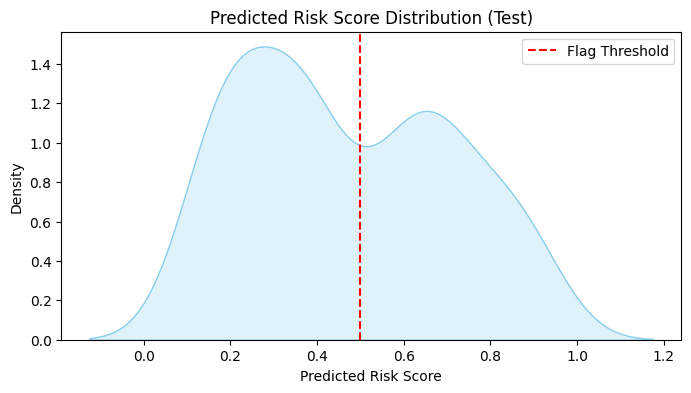

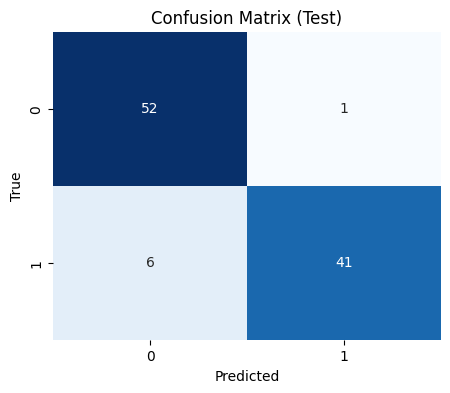

C:\Users\naray\AppData\Local\Temp\ipykernel_35956\810125961.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='muted')


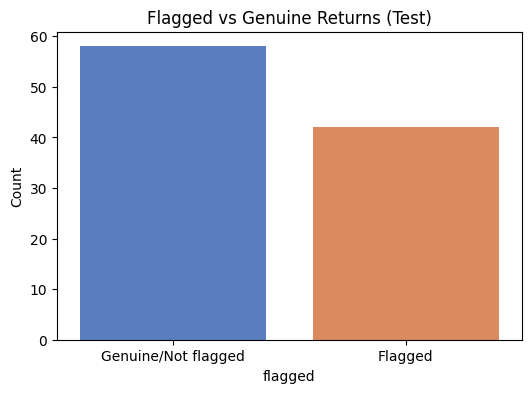

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
os.makedirs('results', exist_ok=True)


# Load test data with predictions
test_df = pd.read_csv('test_risk_predictions.csv')

# 1. Prediction distribution histogram (KDE)
plt.figure(figsize=(8,4))
sns.kdeplot(test_df['predicted_risk'], shade=True, color='skyblue')
plt.axvline(0.5, color='red', linestyle='--', label='Flag Threshold')
plt.title('Predicted Risk Score Distribution (Test)')
plt.xlabel('Predicted Risk Score')
plt.legend()
plt.savefig('results/test_predicted_risk_distribution.png')
plt.show()

# 2. Confusion matrix heatmap
if 'true_label' in test_df.columns:
    cm = confusion_matrix(test_df['true_label'], test_df['flagged'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test)')
    plt.savefig('results/test_confusion_matrix.png')
    plt.show()

# 3. Flagged vs genuine counts bar chart
counts = test_df['flagged'].value_counts().rename({0:'Genuine/Not flagged',1:'Flagged'})
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values, palette='muted')
plt.title('Flagged vs Genuine Returns (Test)')
plt.ylabel('Count')
plt.savefig('results/test_flagged_vs_genuine_counts.png')
plt.show()
